# Prueba y Error

Para modificar ese comportamiento y llevarlo a un comportamiento deseado se suele retocar las ganancias mediante pruebas en LC siguiendo estas reglas:

	- Aumentar la ganancia propocional incrementa las oscilaciones.
    - El error decae más rápidamente si se disminuye el tiempo de integración.
	- Disminuir el tiempo de integración disminuye la estabilidad (aumentan las oscilaciones).
	- Aumentar el tiempo derivativo mejora la estabilidad.
	

In [103]:
import numpy as np
import control as cnt
import control.matlab  as cntm
import matplotlib.pyplot as plt

# TP
R1 = 2.2e3
C1 = 1e-6
R2 = 1e2
C2 = 1e-6

num = [1]
den = [(R1*C1*R2*C2), (R1*C1+R1*C2+R2*C2), 1]
sys = cnt.tf(num, den)
print(sys)

# Define the PID controller transfer function
K  = 1.5
Ti = 0.02
Td = 0.005
# pid = cnt.tf([Kd, Kp, Ki], [1, 0])
pid = cnt.tf([K*Td, K, K/Ti], [1, 0])
# pid1 = cnt.tf([0, 10, 0], [1, 0])
# pid2 = cnt.tf([0, 2, 0], [1, 0])

print(pid)




            1
--------------------------
2.2e-07 s^2 + 0.0045 s + 1


0.0075 s^2 + 1.5 s + 75
-----------------------
           s



0.9999999999999555


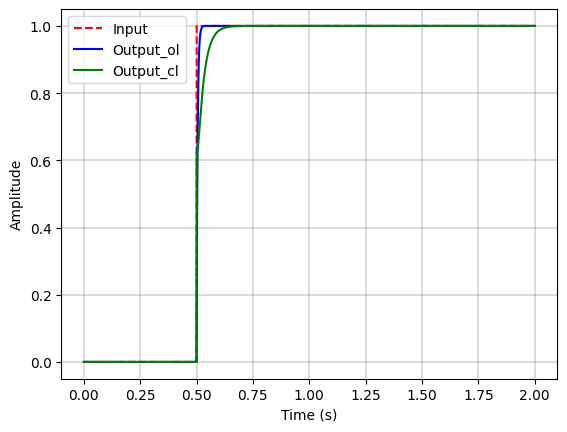

In [104]:
# Define the simulation time and input signal
t = np.linspace(0, 2, 5000)
u = np.append(np.zeros(int(len(t)/4)), np.ones(int(len(t)*3/4)))

# Simulate the closed-loop response
cl_sys  = cnt.feedback(sys*pid, 1)
# y, t = cntm.step(sys, t, 0)

# cl_sys1  = cnt.feedback(sys*pid1, 1)
# cl_sys2  = cnt.feedback(sys*pid2, 1)

t, y_ol = cnt.forced_response(sys, t, u)
t, y_cl = cnt.forced_response(cl_sys, t, u)


print(max(y_cl))

# Plot the results
plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, u, 'r--', label='Input')
plt.plot(t, y_ol, 'b-', label='Output_ol')
plt.plot(t, y_cl, 'g-', label='Output_cl')
# plt.plot(t, y_cl2, 'k-', label='Output_cl2')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

# Ziegler-Nichols

## Método 1: Respuesta al escalón

El método busca aproximar la respuesta al escalón por una recta tangente al cambio de concavidad en la respuesta. A partir de esa aproximación se encuentran los parámetros.

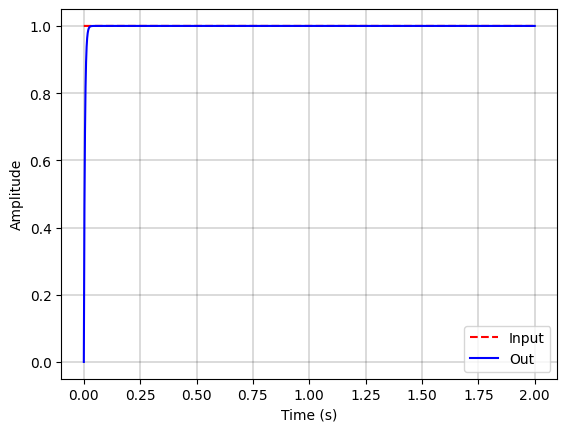

In [105]:
num = [1]
den = [(R1*C1*R2*C2), (R1*C1+R1*C2+R2*C2), 1]
sys = cnt.tf(num, den)

# Define the simulation time and input signal
t = np.linspace(0, 2, 5000)
u = np.ones(len(t))

t, y_ol = cnt.forced_response(sys, t, u)

# Plot the results
plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, u, 'r--', label='Input')
plt.plot(t, y_ol, 'b-', label='Out')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

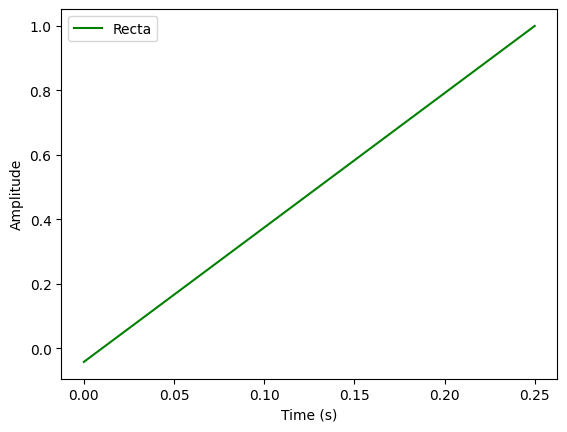

In [106]:
x1 = 0.01
x2 = 0.25
y2 = 1
y1 = 0

# Ecuación de la recta
t1 = np.linspace(0, x2, 5000)
y_r = ((y2-y1)/(x2-x1))*(t1-x1)+y1

plt.plot(t1, y_r, 'g-', label='Recta')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()


28.799999999999997 0.02 0.005


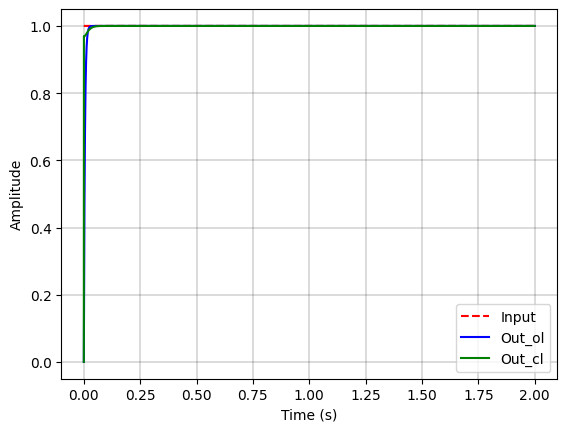

In [107]:
# Ziegler-Nichols Parameters
L = x1
T = x2-x1
# A = B = 1

# PID con Z-N
K  = 1.2*T/L
Ti = 2*L
Td = 0.5*L

print(K,Ti,Td)

pid = cnt.tf([K*Td, K, K/Ti], [1, 0])

cl_sys  = cnt.feedback(sys*pid, 1)
t, y_cl = cnt.forced_response(cl_sys, t, u)

# Plot the results
plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, u, 'r--', label='Input')
plt.plot(t, y_ol, 'b-', label='Out_ol')
plt.plot(t, y_cl, 'g-', label='Out_cl')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

In [108]:
# Verificación del Quarter Decay
print(max(y_cl)-1)
print((max(y_cl)-1)/4)


-8.715250743307479e-14
-2.1788126858268697e-14


## Método 2: Ganancia crítica

En este método se busca llevar al sistema a funcionar en un punto de oscilaciones sostenidas al aumentar la ganancia en lazo cerrado.

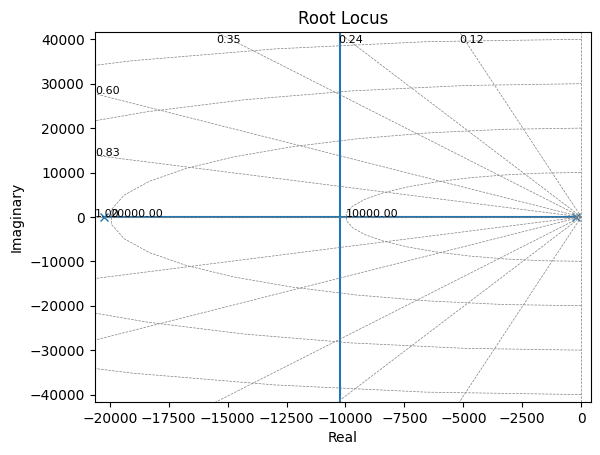

In [109]:
# Sistema en LC con ganancia
%matplotlib inline
g,p = cntm.rlocus(sys)

# Es necesario que los polos del sistema puedan ir hacia el eje imaginario para poder lograr las oscilaciones sostenidas.

# Ubicando Polos y Ceros

Se propone una forma de encontrar las ganancias del PID en función de las especificaciones de diseño

Text(0, 0.5, 'Amplitude')

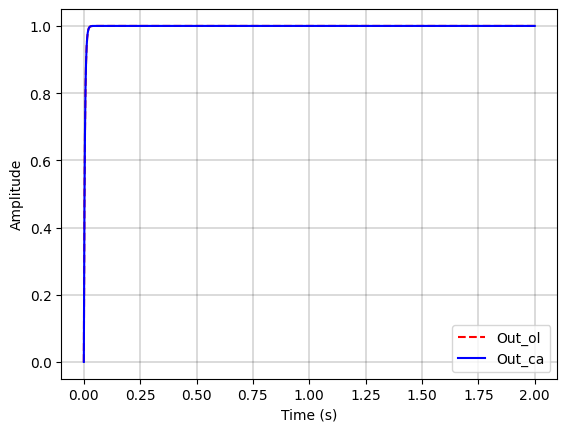

In [110]:
num = [1]
den = [(R1*C1*R2*C2), (R1*C1+R1*C2+R2*C2), 1]
sys = cnt.tf(num, den)

num1 = [1/(R1*C1*R2*C2)]
den1 = [1,(R1*C1+R1*C2+R2*C2)/(R1*C1*R2*C2), 1/(R1*C1*R2*C2)]
sys1 = cnt.tf(num1, den1)


p1,p2 = cnt.poles(sys1)

tau1 = -1/p1.real
tau2 = -1/p2.real

s = cnt.tf('s')
sys2 = (tau1*tau2/(R1*C1*R2*C2))/((s*tau1+1)*(s*tau2+1))

y_ca, t = cntm.step(sys2, t)


plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, y_ol, 'r--', label='Out_ol')
plt.plot(t, y_ca, 'b-', label='Out_ca')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


In [111]:
# Parámetros del sistema en LA
tau1 = -1/p1.real
tau2 = -1/p2.real
ks = tau1*tau2/(R1*C1*R2*C2)
tr = 0.445 - 0.018

# Parámetros del sistema deseado en LC
trd     = 0.7*tr
Mp      = 8/100
# print(trd, Mp)
psi     = mt.sqrt(mt.log(Mp)**2/(mt.pi**2+mt.log(Mp)**2)) # Tiene que ser mayor o igual a ese valor
print(psi)
# Aumentar el psi significa que el sistema en lazo cerrado va a estar cada vez más amortiguado
psi     = psi                                             # Para que el cálculo tenga sentido psi<1 (sub-amortiguado)
phi     = mt.acos(psi)
omega_0 = trd/(mt.exp(phi/mt.tan(phi)))                   # Tiene que ser mayor o igual a ese valor
print(omega_0)
# Aumentar omega indica que el sistema va a tender a tener oscilaciones más rápidas
omega_0 = omega_0 + 6

# Calculo las raices del polinomio de lazo cerrado para saber qué sería un polo "alejado"
p1_lc,p2_lc = np.roots([1,2*psi*omega_0,omega_0**2])

# En función de los polos anteriores se elije el polo restante una decada más lejos
alpha   = 10*max(-p1_lc.real,-p2_lc.real)      
print(psi,phi,omega_0,alpha)

K  = (tau1*tau2*omega_0**2*(1+2*alpha*psi)-1)/ks
Ti = (tau1*tau2*omega_0**2*(1+2*alpha*psi)-1)/(tau1*tau2*alpha*omega_0**3)
Td = (tau1*tau2*omega_0*(alpha+2*psi)-tau1-tau2)/(tau1*tau2*omega_0**2*(1+2*alpha*psi)-1)

# Verificar que todas las ganancias del controlador den positivas (sintetiza un mejor controlador)
print('Ganancias del PID:',K,Ti,Td)
# Td podría ser negativo, pero podría generar algunas complicaciones de implementación


0.6265771868559205
0.14571492184239113
0.6265771868559205 0.8936427395335057 6.145714921842391 38.50764766946458
Ganancias del PID: -0.9995907140067357 -508.31779038403886 0.004448061647356781


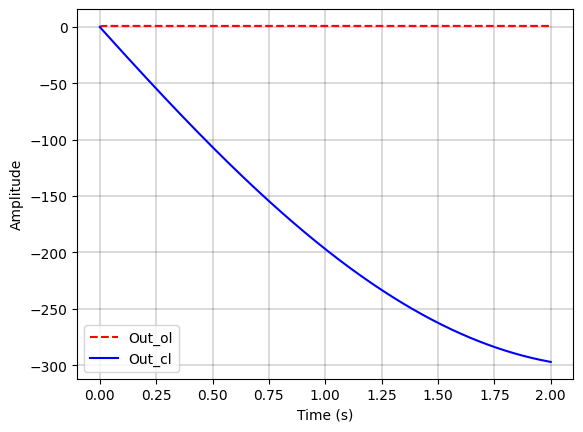

In [112]:
%matplotlib inline
# Define time
t = np.linspace(0, 2, 5000)

pi = cnt.tf([K,K/Ti], [1, 0])

cl_sys  = cnt.feedback(sys*pi, 1)
y_cl, t = cntm.step(cl_sys, t)

# Plot the results
plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, y_ol, 'r--', label='Out_ol')
plt.plot(t, y_cl, 'b-', label='Out_cl')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

In [113]:
# Define a function to calculate the rise time
def calculate_rise_time(signal, time,ref_value=1):
    # Find the index where the signal first crosses the start threshold
    start_index = np.argmax(signal >= 0.1*ref_value)
    
    # Find the index where the signal crosses the end threshold
    end_index = np.argmax(signal >= 0.9*ref_value)
    
    # Calculate the rise time as the difference between the two indices, multiplied by the time step
    rise_time = time[end_index] - time[start_index]
    
    return rise_time

In [114]:
rt = calculate_rise_time(y_ol,t)
print('Tiempo de subida en LA:',tr)
print('Tiempo de subida deseado:',0.7*tr)

Tiempo de subida en LA: 0.427
Tiempo de subida deseado: 0.2989


In [115]:
rt_cl = calculate_rise_time(y_cl,t)
print(rt_cl,max(y_cl))

0.0 0.0
